In [66]:
import pandas as pd
import numpy as np
import re
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

### Grid Search:

Grid search will optimize model on the training data 2005,2006 and validate on 2007.

- First we will implement a gridsearch across varying alphas for polynomial of degree 2
- Second we will implement a gridsearch across varying alphas for polynomial of degree 1

In [67]:
year_from = 2002

def load_data(year_from):  
    assert isinstance(year_from,int)
    # Imports
    train = pd.read_csv('data/TrainingSet.csv',index_col=0)
    submission = pd.read_csv('data/SubmissionRows.csv',index_col=0)
    # Remove [YR****] and input '_' for last 3 cols
    train.columns = list(map(lambda x: re.findall(r'\d+',x)[0],train.columns[:36])) + list(map(lambda x: '_'.join(x.split()),train.columns[36:]))
    # Use last 3 years for predictions: This is subjected to change
    train = train.loc[:,f'{year_from}':]
    return train, submission

# Load data:
train, submission = load_data(year_from)

# Interpolate: Missing values
def interpolate_data(train,submission):
    train_X = train.loc[submission.index,:]
    # Interpolate: Both directions are bfilled and ffilled respectively
    train_X.loc[:,:'2007'] = train_X.loc[:,:'2007'].interpolate(limit_direction='both',axis=1)
    return train_X

# Data:
data = interpolate_data(train,submission)

# Func to split that dataframe to values [2005,2006,2007] and [country_name,series_code,series_name]
def split_dataframe(data):
    raw_data = data.loc[:,:'2007']
    description = data.loc[:,'Country_Name':]
    return raw_data,description

# Split:
raw_data,description = split_dataframe(data)

def format_dataframe(raw_data):
    """
    Quick utility function to format dataframe into a X,y format with X = Numbers of years from the start, y = values.
    Example:
    Initial Dataframe being:
    2005   0.4
    2006   0.6
    2007   0.8
    
    The function transforms it into
    X   y
    0   0.4
    1   0.6
    2   0.8
    
    Returns: X,y
    
    Note: If we have 10 different timeseries (features) X.shape = (n_years,n_features) so slicing will be needed to predict
    individually.
    """
    # Extract index from raw data before transforming:
    raw_data_index = list(raw_data.index)
    raw_data.columns = raw_data.columns.astype('int')
    # Transponse to have time as index instead of columns
    raw_data = raw_data.T
    X = np.asarray(raw_data.index - raw_data.index[0]).reshape(-1,1)
    y = raw_data.values
    return X,y,raw_data_index



In [68]:
# Dim 2: [timesteps, features]
X,y,raw_data_index = format_dataframe(raw_data)

In [69]:
def ridge_regression(X,y,degree,alpha):
    pipe = Pipeline([('poly',PolynomialFeatures(degree=degree)),('linear',Ridge(alpha=alpha))])
    # Fit predict:
    pipe.fit(X,y)
    return pipe

In [70]:
# Create a gridsearch for Ridge regression alpha:
class Gridsearch(object):
    """
    Validation year will be the last year. 
    Example:
    X        y
    2005     3
    2006     5
    2007     6
    
    Then the validation year will be 2007 and model will be fit with prior years (2005,2006). This method is specific for the current dataset
    where we have limited number of years.
    """
    
    def __init__(self,alpha_list):
        self.alpha_list = alpha_list
    def fit_predict(self,X,y,degree):
        self.X_train = X[:-1,:]
        self.y_train = y[:-1,:]
        self.degree = degree
        self.X_test = X[-1,:].reshape(-1,1) # Last year for validation
        self.y_test = y[-1,:].reshape(-1,1) # Last year true values
        n_features = self.y_train.shape[1]
        # Results of gridsearch:
        alpha_results = defaultdict(float)
        for alpha in self.alpha_list:
            squared_errors = list()
            for i in range(n_features):
                # Select ith feature to fit:
                pipe = ridge_regression(X=self.X_train,y=self.y_train[:,i],degree =self.degree,alpha=alpha)
                # X_test:
                y_pred = pipe.predict(self.X_test)
                y_true = self.y_test[i]
                # Take the squared error (y_true - y_pred)**2. Append to squared errors.
                i_squared_error = math.pow((y_pred[0] - y_true[0]),2)
                squared_errors.append(i_squared_error)
            # Root mean squared error:
            rmse_alpha = math.sqrt(sum(squared_errors)/n_features)
            alpha_results[alpha] = rmse_alpha
        return alpha_results

In [71]:
# Func: Returns the best score with respective alpha
def best_score(grid_fit_predict):
    ordered_scores = sorted(grid_fit_predict.items(),key=lambda x:x[1])[0]
    alpha_best, score = ordered_scores
    return alpha_best, score

# Plot validation errors for alphas and print best score with alpha
def plot_val_error(grid_fit_predict):
    """
    Using fit predict method from Gridsearch, this function will plot the validation scores of the last year in training set (usually 2007)
    """
    plt.figure(figsize=(10,6))
    plt.plot(list(grid_fit_predict.keys()),list(grid_fit_predict.values()),marker='o')
    plt.xlabel('Alphas')
    plt.ylabel('RMSE score')
    plt.show()
    # Print best alpha with score
    alpha_best, score = best_score(grid_fit_predict)
    print(f'The best score is {score} with alpha = {alpha_best}')

### Polynomial degree = 3

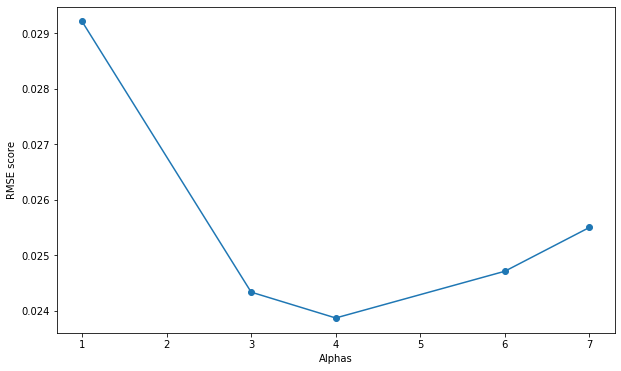

The best score is 0.023871144766133938 with alpha = 4


In [72]:
# Instantiate gridsearch:
grid = Gridsearch([1,3,4,6,7])
# Fit predict: polynomial degree = 2
grid_fit_predict = grid.fit_predict(X,y,3)
# Plot:
plot_val_error(grid_fit_predict)

### Polynomial degree = 2 

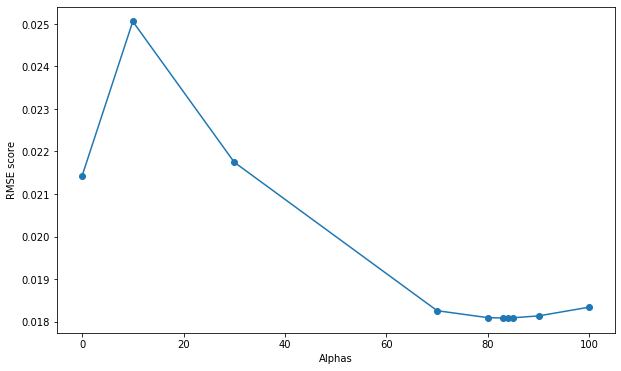

The best score is 0.018083938502996885 with alpha = 83


In [73]:
# Instantiate gridsearch: Try alpha = 83
grid = Gridsearch([0,10,30,70,80,83,84,85,90,100])
# Fit predict: polynomial degree = 2
grid_fit_predict = grid.fit_predict(X,y,2)
# Plot:
plot_val_error(grid_fit_predict)

### Polynomial degree = 1

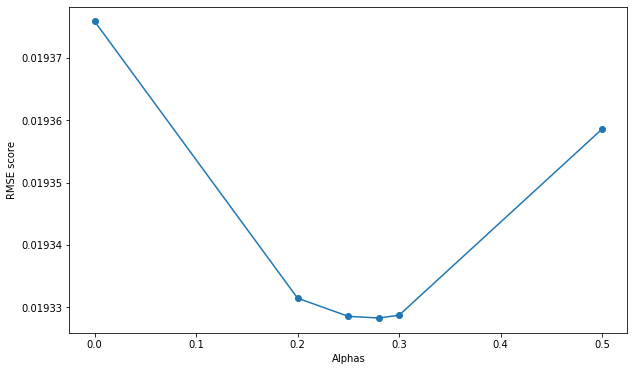

The best score is 0.019328257225815153 with alpha = 0.28


In [74]:
# Instantiate gridsearch:
grid = Gridsearch([0,0.2,0.25,0.28,0.3,0.5])
# Fit predict: polynomial degree =1
grid_fit_predict = grid.fit_predict(X,y,1)

# Plot:
plot_val_error(grid_fit_predict)

### Final optimized hyperparameter to try based on grid search:

- Polynomial degree = 2, alpha = 83
- Alternatively try Polynomial degree = 1, alpha = 0.28 